In [1]:
import scipy.sparse as spr
import scipy.sparse.linalg as spla
import sys
path2oti = '../../../../build/'
sys.path.append(path2oti) # Add path to OTI library.

import pyoti.real   as r
import pyoti.sparse as oti 
import pyoti.core   as coti
import pyoti.fem    as fem 

# import pyoti.static.onumm1n1    as dual
# # import pyoti.static.mdnum2      as md2
# # import pyoti.static.mdnum3      as md3
# # import pyoti.static.mdnum5      as md5
# import pyoti.static.mdnum6      as md6
# # import pyoti.static.mdnum10     as md10
# # import pyoti.static.onumm1n10   as om1n10
# # import pyoti.static.onumm1n2    as om1n2
# import pyoti.static.onumm1n5    as om1n5
# # import pyoti.static.onumm5n5    as om5n5
# # import pyoti.static.onumm2n2    as om2n2
# # import pyoti.static.onumm3n3    as om3n3
# import pyoti.static.onumm2n10    as om2n10




%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

e  = oti.e
np = oti.np

alg = fem.get_global_algebra()

import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')

global times
from timeit import default_timer as time

from matplotlib import rc

## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})
rc('text', usetex=True)

In [2]:
#*****************************************************************************************************
def solve_2d_axisymmetric_heat_conduction(Th, Bii, Bio, s, stats=True, solver = 'SuperLU'):
    
    global times
    from timeit import default_timer as time
    
    print("Setting up problem")
    
    start_time = time()
    
    
    ndim_analysis = 2
    
    els = Th.elements[2]

    fem.end_elements()
    
    nNodes = Th.nnodes
    nDOF = nNodes
    
    K = alg.lil_matrix((nDOF,nDOF))
    f = alg.zeros((nDOF,1))
    
    print("\nStarting elemental computations.")
    
    #  INT 2D
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=8)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = True)

            fh = alg.zeros( ( elem.nbasis, 1 ) )
            r    = alg.zero(    nip = elem.nip   )
            rneg = alg.zero(    nip = elem.nip   )
            rinv = alg.zero(    nip = elem.nip   )
            
            # Temps
            NT  = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            NxT = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            NyT = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            
            NxNx = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NyNy = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NNx  = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )

            NN_tmp1 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NN_tmp2 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NN_tmp3 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            
            N_tmp1 = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            N_tmp2 = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            N_tmp3 = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            
            tmp_Ke = alg.zeros( ( elem.nbasis, elem.nbasis ) )
            tmp_fe = alg.zeros( ( elem.nbasis,       1     ) )

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            Nx = elem.Nx
            Ny = elem.Ny
            N  = elem.N
            x  = elem.x # Extract x-coordinates.
            
            alg.transpose(Nx, out = NxT)
            alg.transpose(Ny, out = NyT)
            alg.transpose( N, out = NT )
            
            alg.dot( NxT, Nx, out = NxNx )
            alg.dot( NyT, Ny, out = NyNy )
            
            
            
            alg.dot_product( x, NT, out = r ) 
            
            alg.neg( r , out = rneg)
            
            alg.div( 1.0, r , out = rinv)
            
            # problem heat(Theta,w)=
            #    -int2d(Th)(    dx(Theta) * dx(w) ) // -- Goes in K
            #    -int2d(Th)(    dy(Theta) * dy(w) ) // -- Goes in K
            #    +int2d(Th)(    dx(Theta) * w / x ) // -- Goes in K            
            #    +int2d(Th)(    Q * w             ) // -- RHS only
            #
            #    -int1d(Th,4)(  w * Bi1 * Theta   ) // -- Goes in K
            #    -int1d(Th,2)(  w * Bi2 * Theta   ) // -- Goes in K
            #    -int1d(Th,2)(  w * Bi2           );// -- RHS only
                      
            alg.sum( NxNx, NyNy, out = NN_tmp1 )
            alg.neg(    NN_tmp1, out = NN_tmp2 )
            
            alg.mul( rinv, NT, out =  N_tmp1 )
            alg.dot(  N_tmp1, Nx, out = NNx )
            alg.sum( NNx, NN_tmp2, out = NN_tmp3)
            
            alg.gauss_integrate( NN_tmp3, elem.dV, out = tmp_Ke )
            
            
            alg.mul(    s,    NT, out = N_tmp1 )
            alg.neg(    N_tmp1, out = N_tmp2 )
            alg.gauss_integrate( N_tmp2, elem.dV, out = tmp_fe )
            
          
            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])
            
                f[ii,0] = f[ii,0] + tmp_fe[k,0]
                
                for l in range(elems.size):

                    jj=int(elems[l])
            
                    K[ii,jj] = K[ii,jj] + tmp_Ke[k,l]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()   

    end_assmbly_time = time()
    print("\nFinished assembly.\nSetting up boundary condition.")
    
    # 
    els = Th.group_names['left']['members'][0]
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=8)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = False)
         
        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            N  = alg.transpose(elem.N)
            r  = alg.dot_product( elem.x, N ) 
            
            NN = alg.dot(N,elem.N)
            
            #    -int1d(Th,4)(  x * w * Bi1 * Theta   ) // -- Goes in K
            #    -int1d(Th,2)(  x * w * Bi2 * Theta   ) // -- Goes in K
            #    -int1d(Th,2)(  x * w * Bi2           );// -- RHS only
            
            tmp_Ke = -alg.gauss_integrate( (Bii)*NN, elem.dV)
            # tmp_fe = alg.gauss_integrate( (Bii)*N, elem.dV)
            
            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])
            
                # f[ii,0] = f[ii,0] + tmp_fe[k,0]
                
                for l in range(elems.size):

                    jj=int(elems[l])
            
                    K[ii,jj] = K[ii,jj] + tmp_Ke[k,l]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()  
    
    els = Th.group_names['right']['members'][0]
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=8)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = False)

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            N  = alg.transpose(elem.N)
            r  = alg.dot_product( elem.x, N ) 
            
            NN = alg.dot(N,elem.N)
            
            #    -int1d(Th,4)(  w * Bi1 * Theta   ) // -- Goes in K
            #    -int1d(Th,2)(  w * Bi2 * Theta   ) // -- Goes in K
            #    -int1d(Th,2)(  w * Bi2           );// -- RHS only
            
            tmp_Ke = -alg.gauss_integrate( (Bio)*NN, elem.dV)
            tmp_fe =  alg.gauss_integrate( (Bio)*N , elem.dV)
            
            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])
            
                f[ii,0] = f[ii,0] + tmp_fe[k,0]
                
                for l in range(elems.size):

                    jj=int(elems[l])
            
                    K[ii,jj] = K[ii,jj] + tmp_Ke[k,l]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()
    
    end_bc_time = time()
    
    print("\nEnded boundary condition setup.\nStarting system solution.")
    
    u = 0
    K = K.tocsr()#(preserve_in=False)
    
    print("\nConverted matrix to csr format. - Starting solution process.")
    
    u = alg.solve(K,f,solver=solver)
    
    print("\nSolved problem.")
    
    end_solve_time = time()
    
    if stats:
        times['assembly'].append(  end_assmbly_time - start_time       )
        times['bc'].append( end_bc_time      - end_assmbly_time  )
        times['solve'].append(  end_solve_time   - end_bc_time      )
        times['total'].append( end_solve_time   - start_time        )
        
#         print("Assembly time:  {0:.6f} s ".format( end_assmbly_time - start_time       ) )
#         print("Boundary time:  {0:.6f} s ".format( end_bc_time      - end_assmbly_time ) )
#         print("Solution time:  {0:.6f} s ".format( end_solve_time   - end_bc_time      ) )
        print("Total run time: {0:.6f} s ".format( end_solve_time   - start_time       ) )
        print()
    # end if 

    return u,K,f

    #-----------------------------------------------------------------------------------------------------

In [3]:
def analytic_solution_r( r, Bii, Bio, s, ri, ro, log = alg.log):
    
    #real K1 = ( 2.0 * Bi2 * Q - Bi1 * Bi2 * Q + 2.0 * Bi1 * Q * rho - 4.0*Bi1*Bi2 + Bi1*Bi2*Q*rho^2);
    #
    #real KDiv = (Bi1*Bi2*rho*log(rho)+Bi1+Bi2*rho);
    #
    #real K2 = (2.0*Q*rho^2-4.0*Bi2*rho+Bi2*Q*rho^3-2.0*Bi2*Q*rho*log(rho)+
    #           Bi1*Bi2*Q*rho*log(rho)-2.0*Q+Bi1*Q);

    # ThetaAnalytic = -0.25*Q*x^2 + 0.25*rho*log(x)*K1/KDiv + 0.25*K2/KDiv;
    
    
    rho = ro/ri
    
    K1 = ( 2.0 * Bio * s - Bii * Bio * s + 2.0 * Bii * s * rho - 4.0 * Bii * Bio + Bii * Bio * s * rho**2)
    
    KDiv = ( Bii * Bio * rho * log(rho) + Bii + Bio * rho )
    
    K2 = ( 2.0 * s * rho**2 - 4.0 * Bio * rho + Bio * s * rho**3 - 2.0 * Bio * s * rho * log(rho) +
           Bii * Bio * s * rho * log(rho) - 2.0 * s + Bii * s )


    Theta = - 0.25 * s * r**2 + 0.25 * rho * log(r) * K1 / KDiv + 0.25 * K2 / KDiv
    
    return Theta

In [9]:
# r, dual, md2, md3, md5, md10, om1n10, 
# om1n2, om1n5, om5n5, om2n2, om3n3, oti
# fem.set_global_algebra(r)
# fem.set_global_algebra(dual)
# fem.set_global_algebra(om1n5)
fem.set_global_algebra(oti)
# fem.set_global_algebra(dual)
alg = fem.get_global_algebra()

start_time = time()

he = 0.0005
hy = 2*he
Th = fem.square(0.5,hy,he=he,element_order=2,quads=True,save=False, structured=True)


end_time = time()
print(end_time - start_time,"seg")

# Translate the xaxis such that x \in [ 1, 1.5]
Th.x = Th.x + 1.25 
Th

0.018748372967820615 seg


< mesh (pyoti.sparse) object with 8005 nodes, 4008 elements of types ( point1 (4), line3 (2004), quad8 (2000) ) >

In [10]:
order = 30


Bii = alg.number(0.1)+alg.e(1, order = order)
Bio = alg.number(1.0)+alg.e(2, order = order)
s   = alg.number(5.0)+alg.e(3, order = order)

ri  = alg.number(1.0)#+alg.e(3, order = order)
ro  = alg.number(1.5)#+alg.e(1, order = order)

solver = 'umfpack'

# # Perturb nodal coordinates for ro
# pc = 1.0


# for i in range(Th.x.size):

#     x = Th.x[i,0]
    
#     if x.real > (ro-pc*(ro-ri)).real:
        
#         h = (1-(ro-x)/(pc*(ro-ri))).real

#         Th.x[i,0] = x.real + h * alg.e( 1, order = order)
        
#     else:

#         Th.x[i,0] = x.real
    
#     # end if 
    
# # end for 


In [11]:
times = {}
times['assembly'] = []
times['bc'] = []
times['solve'] = []
times['total'] = []



for i in range(1):
    u,K,f = solve_2d_axisymmetric_heat_conduction(Th,Bii,Bio,s,solver=solver)
#end for

print('\n\nTimes:'+str(type(u)))
print("- Avg Assembly time:  {0:.6f} s ".format(np.average(times['assembly'] ) ) )
print("- Avg Boundary time:  {0:.6f} s ".format(np.average(times['bc'])      ) )
print("- Avg Solution time:  {0:.6f} s ".format(np.average(times['solve'])   ) )
print("- Avg Total run time: {0:.6f} s ".format(np.average(times['total'])   ) )

Setting up problem

Starting elemental computations.

Finished assembly.
Setting up boundary condition.

Ended boundary condition setup.
Starting system solution.

Converted matrix to csr format. - Starting solution process.

Solved problem.
Total run time: 71.467063 s 



Times:<class 'pyoti.sparse.matso'>
- Avg Assembly time:  24.253553 s 
- Avg Boundary time:  0.001139 s 
- Avg Solution time:  47.212372 s 
- Avg Total run time: 71.467063 s 


In [12]:
K

<(8005, 8005) sparse matrix of OTI numbers with 
         102017 stored elements in Compressed Sparse Row format>

In [8]:
oti.save(u,"u_dro_pc100_n"+str(order)+".matso")

In [17]:
Th.group_names['right']['members'][0]['nodes']-1

array([   2,    3, 2006, 2007, 2008], dtype=uint64)

In [20]:
Th.x[3]

matso< shape: (1, 1), 
 - Column 0
(0,0) 1.5 + 1 * e([1])
>

In [24]:
u_eval=u[0,0]
u.real

# array([[1.47412494],
#        [1.47412494],
#        [0.98505834],
#        ...,
#        [0.9865461 ],
#        [0.98605041],
#        [0.98555449]])

array([[1.47412494],
       [1.47412494],
       [0.98505834],
       ...,
       [0.9865461 ],
       [0.98605041],
       [0.98555449]])

In [49]:
u_a =  analytic_solution_r( Th.x, Bii, Bio, s, ri, ro, log = alg.log)

In [30]:
analytic_solution_r( 1, Bii, Bio, s, 1, 1.5+0.8, log = alg.log)

6.1621

In [29]:
u_eval.taylor_integrate([1],[0.8])


6.1432

In [11]:
u_a.real

array([[1.47412494],
       [1.47412494],
       [0.98505834],
       ...,
       [0.9865461 ],
       [0.98605041],
       [0.98555449]])

In [12]:
Th.group_names['left']['nodes']
Th.x[4]

matso< shape: (1, 1), 
 - Column 0
(0,0) 1
>

In [31]:
i = 0
delta = 1e30
val   = 0
theta = 0
for idx in Th.group_names['left']['nodes']:
    y = Th.y[int(idx),0].real
    
    if np.abs(y - val) < delta:
        delta = np.abs(y - val)
        i = int(idx)
print(i)
idx = int(i)

4


In [50]:
# Compute the relative errors of the derivative dudro(ri) for all computed orders.
# idx = 350
imbase = 1
errors = np.zeros(order+1)

u_err = np.abs((u - u_a).real)/np.abs((u_a).real)

errors[0] = np.abs(u_err[idx,0])


ui = u[idx,0]
u_ai = u_a[idx,0]


for ordi in range(1,order + 1):
    dudE = ui.get_deriv( [[imbase,ordi]] )
    
    dudE_a = u_ai.get_deriv([[imbase,ordi]])
    
    if dudE_a.real == 0:
        dudE_rerr=np.abs(dudE - dudE_a)
    else:
        dudE_rerr=np.abs(dudE - dudE_a)/np.abs(dudE_a)
    
    errors[ordi] = np.abs(dudE_rerr)
# end for 

In [51]:
# np.save("errors_tri6_h01_ndofs.npy",errors)
# errors


errors_Bio_ = np.array([7.61593631e-11, 1.50114387e-10, 2.36825437e-10, 3.23525211e-10,
       4.10236813e-10, 4.96940633e-10, 5.83641796e-10, 6.70349829e-10,
       7.57054824e-10, 8.43760226e-10, 9.30473428e-10, 1.01716951e-09,
       1.10387553e-09, 1.19058533e-09, 1.27729032e-09, 1.36399672e-09,
       1.45069936e-09, 1.53740391e-09, 1.62411302e-09, 1.71081841e-09,
       1.79752322e-09, 1.88423164e-09, 1.97093228e-09, 2.05764517e-09,
       2.14434751e-09, 2.23105073e-09, 2.31776187e-09, 2.40446619e-09,
       2.49117329e-09, 2.57788027e-09, 2.66458625e-09])

errors_Bii_ = np.array([7.61593631e-11, 1.46896178e-10, 2.16204090e-10, 2.85514363e-10,
       3.54834315e-10, 4.24148617e-10, 4.93463300e-10, 5.62776832e-10,
       6.32098320e-10, 7.01412893e-10, 7.70727358e-10, 8.40040932e-10,
       9.09356038e-10, 9.78671874e-10, 1.04798359e-09, 1.11730152e-09,
       1.18661257e-09, 1.25592266e-09, 1.32523859e-09, 1.39455457e-09,
       1.46386867e-09, 1.53318966e-09, 1.60250675e-09, 1.67182210e-09,
       1.74113610e-09, 1.81044358e-09, 1.87976026e-09, 1.94907843e-09,
       2.01839085e-09, 2.08770575e-09, 2.15702236e-09])

errors_s_ = np.array([7.61593631e-11, 8.48410203e-11, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])


errors_ro_ord2 = np.array([7.61593631e-11, 5.03159510e-11, 2.17561208e-10, 5.99352149e-09,
       1.24918930e-08, 7.51266563e-08, 4.09977444e-07, 4.40496936e-08,
       1.32091763e-06, 7.74014297e-06, 2.92823832e-05, 2.18761549e-04,
       1.46536937e-03, 5.02738388e-03, 3.69043275e-03, 8.76232370e-03,
       1.31180844e-01, 3.25278399e-02, 1.99665799e-01, 1.69810028e+00,
       1.25524426e+01, 4.84979645e+01, 8.06356668e+01, 4.13614743e+02,
       1.48563378e+03, 2.41659524e+04, 8.37283611e+04, 2.23332486e+05,
       4.90738365e+05, 6.86934679e+05, 1.47694741e+07])

errors

array([8.08797457e-12, 3.17044284e-11, 6.85443220e-10, 2.25150414e-08,
       4.29744946e-09, 5.71372988e-09, 3.06120493e-07, 4.92342633e-07,
       1.66658295e-06, 7.24732912e-06, 3.55733553e-05, 7.67663902e-05,
       8.06303319e-04, 3.10302359e-03, 3.35975963e-03, 2.49651756e-02,
       1.71472897e-01, 6.38851233e-02, 5.66067838e-01, 1.20974761e+00,
       1.59845140e+01, 7.22614041e+01, 1.23633160e+02, 5.26748091e+02,
       1.38624847e+03, 2.39161657e+04, 7.40575120e+04, 2.03848061e+05,
       4.74632076e+05, 9.19917734e+05, 1.43412783e+07])

In [52]:
from matplotlib.ticker import MultipleLocator
rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})

<IPython.core.display.Javascript object>


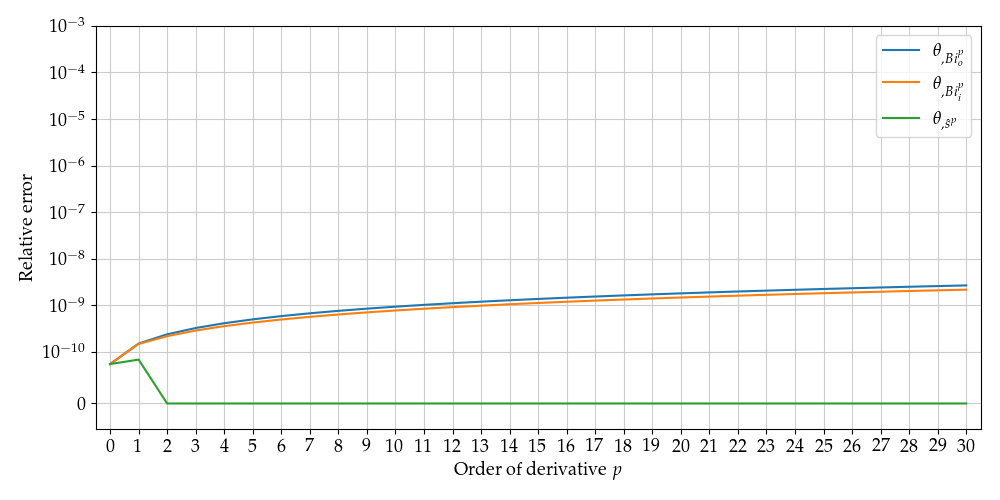

In [69]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':13})
plt.figure(figsize=(10,5))
new_order = order
xvals  = range(new_order+1)#order+1)



yvals = errors_Bio_[:new_order+1]
plt.semilogy(xvals,yvals, label='$\\theta_{,Bi_{o}^{p}}$')

# yvals = errors_ro_ord1[:new_order+1]
# plt.semilogy(xvals,yvals, label='$\\theta_{,r_{o}^{p}}$ tri3')

# yvals = errors_ro_ord2[:new_order+1]
# plt.semilogy(xvals,yvals, label='$\\theta_{,r_{o}^{p}}$')

yvals = errors_Bii_[:new_order+1]
plt.semilogy(xvals,yvals, label='$\\theta_{,Bi_{i}^{p}}$')

yvals = errors_s_[:new_order+1]
plt.semilogy(xvals,yvals, label='$\\theta_{,\hat{s}^{p}}$')

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set_axisbelow(True)
plt.yscale('symlog',linthreshy=1e-10)
# plt.rc('xtick',fontsize=14)
plt.grid(which='major',color='#CCCCCC')
plt.minorticks_on()
plt.grid(which='minor',color='#EEEEEE')
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.axis([-0.5,len(xvals)-1+0.5,-5e-11, 1e-3])
plt.ylabel("Relative error ")
plt.xlabel("Order of derivative $p$")
plt.legend()
plt.tight_layout()

plt.savefig("imgs/error_dThetadBii_n"+str(new_order)+".pdf",dpi=150)
plt.show()

<IPython.core.display.Javascript object>


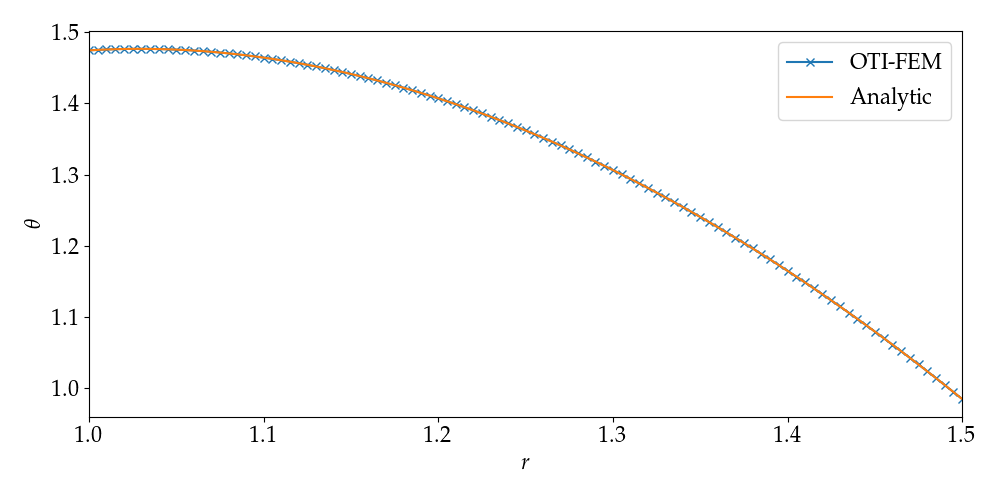

In [174]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})

plt.figure(figsize=(10,5))

grid = Th.to_pv(pd = [u.real],pd_names=['u'])
eps = 1e-2

a = [ri.real,0,0]
b = [ro.real,0,0]

grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

ax = plt.gca()

lines = ax.get_lines()
line = lines[0]
line.set_label("OTI-FEM")
line.set_marker("x")

x = line.get_xdata()
line.set_xdata(x+ri.real)



grid = Th.to_pv(pd = [u_a.real],pd_names=['ua'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

lines = ax.get_lines()
line = lines[-1]
line.set_label("Analytic")

x = line.get_xdata()
line.set_xdata(x+ri.real)

plt.xlabel("$r$")
plt.ylabel("$\\theta$")
# plt.title("OTI solution vs Analytic solution")
plt.title("")
plt.legend()#loc='lower right')
plt.axis([ri.real,ro.real,None,None])
plt.tight_layout()
plt.savefig("imgs/heat/solution_u.pdf",dpi=150)
#plt.legend()
plt.show()

In [20]:
def analytic_solution_xy(x,y,E,nu,ri,pi,ro,po):
    
    A = ri**2*ro**2*(po-pi)/(ro**2-ri**2)
    B = (ri**2*pi - ro**2*po)/(ro**2-ri**2)
    
    r =  (x**2+y**2)**0.5
    
    ur = (1+nu)*r/E*((1-2*nu)*B-A/(r**2))
    
    ux = ur*x/r
    uy = ur*y/r
    
    return ux, uy

In [85]:
x = Th.x[i,0]

In [90]:
x30 = x**30
x30.truncate([[1,30]])

0.0458 + 0.6863 * e([1]) + 4.9754 * e([[1,2]]) + 23.2180 * e([[1,3]]) + 78.3582 * e([[1,4]]) + 203.7250 * e([[1,5]]) + 424.4138 * e([[1,6]]) + 727.5436 * e([[1,7]]) + 1045.8110 * e([[1,8]]) + 1278.1732 * e([[1,9]]) + 1342.0396 * e([[1,10]]) + 1219.9976 * e([[1,11]]) + 965.8011 * e([[1,12]]) + 668.6105 * e([[1,13]]) + 405.9293 * e([[1,14]]) + 216.4888 * e([[1,15]]) + 101.4759 * e([[1,16]]) + 41.7829 * e([[1,17]]) + 15.0878 * e([[1,18]]) + 4.7644 * e([[1,19]]) + 1.3102 * e([[1,20]]) + 0.3119 * e([[1,21]]) + 0.0638 * e([[1,22]]) + 0.0111 * e([[1,23]]) + 0.0016 * e([[1,24]]) + 0.0002 * e([[1,25]]) + 0.0000 * e([[1,26]]) + 0.0000 * e([[1,27]]) + 0.0000 * e([[1,28]]) + 0.0000 * e([[1,29]])

In [35]:
type(u_eval)

pyoti.sparse.sotinum

In [37]:
t = np.linspace(0.0,1.0*ro.real,100)
orders_ti = np.array([30,20,15,10,8,6,4,3,2,1],dtype=np.uint8)
error_ti = np.zeros((orders_ti.size,t.size))

kk=0

ui = u_eval.copy()
xi = Th.x[i,0]
yi = Th.y[i,0]

for ordi in orders_ti:
    u_for_ti = ui.truncate([[1,ordi+1]])
    k = 0
    for delta in t:
        u_r_ti = u_for_ti.taylor_integrate([1],[delta]).real

        u_analyt = analytic_solution_r( xi, 
                                       Bii, 
                                       Bio, 
                                       s, 
                                       ri, 
                                       ro.taylor_integrate([1],[delta]).real, 
                                       log = alg.log
                                      ).real

        error_ti[kk,k]=abs( (u_r_ti-u_analyt)/(u_analyt) )

        k+=1

    #
    kk+=1
error_ti

array([[1.08916150e-11, 9.08012147e-12, 7.66649601e-12, 6.64758888e-12,
        6.01867092e-12, 5.77912143e-12, 5.92314717e-12, 6.45197761e-12,
        7.36125159e-12, 8.65046872e-12, 1.03219098e-11, 1.23724050e-11,
        1.48010007e-11, 1.76011832e-11, 2.07597155e-11, 2.42522264e-11,
        2.80298252e-11, 3.20113886e-11, 3.60598381e-11, 3.99513270e-11,
        4.33362010e-11, 4.56608174e-11, 4.60744957e-11, 4.32632726e-11,
        3.51699144e-11, 1.85111214e-11, 1.21479417e-11, 6.61196825e-11,
        1.59813842e-10, 3.22378892e-10, 6.04754852e-10, 1.09185067e-09,
        1.91260400e-09, 3.22811194e-09, 5.14111327e-09, 7.38404145e-09,
        8.45422925e-09, 3.46981320e-09, 2.07764238e-08, 9.66433026e-08,
        2.98380604e-07, 7.88294122e-07, 1.90779102e-06, 4.35244584e-06,
        9.50112447e-06, 2.00222881e-05, 4.09704062e-05, 8.17351647e-05,
        1.59452538e-04, 3.04887031e-04, 5.72436866e-04, 1.05693353e-03,
        1.92150829e-03, 3.44328692e-03, 6.08750521e-03, 1.062648

<IPython.core.display.Javascript object>


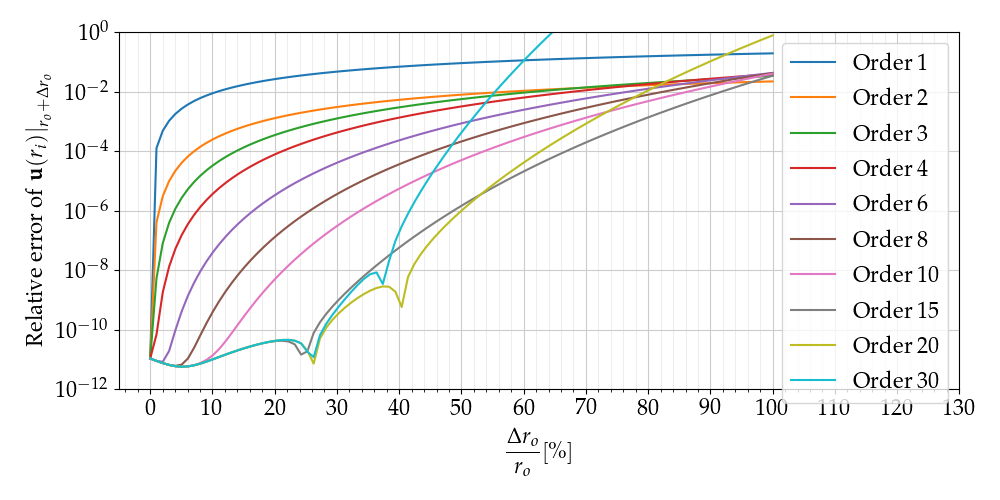

In [45]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})

plt.figure(figsize=(10,5))
norders = len(orders_ti)
for kk in range(norders):
    plt.semilogy(100*t/ro.real,error_ti[-1-kk,:],label="Order "+str(orders_ti[-1-kk]))

plt.ylabel("Relative error of $\\left.\\mathbf{u}(r_i)\\right|_{r_o+\\Delta r_o}$")
plt.xlabel("$\\displaystyle{\\frac{\Delta r_o}{r_o}} [ \% ]$")
plt.legend()

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(10))

ax.set_axisbelow(True)
# plt.rc('xtick',fontsize=14)
plt.grid(which='major',color='#CCCCCC')
plt.minorticks_on()
plt.grid(which='minor',color='#EEEEEE')

ax.xaxis.set_minor_locator(MultipleLocator(2))
# plt.axis([-0.5,len(xvals)-1+0.5,1e-7, 1e-1])
# plt.ylabel("Relative error of $\mathbf{u}_{, r_{o}^{p}}(r_{i})$")
# plt.xlabel("Order of derivative $p$")
plt.axis([None,100*1.3,1e-12,1e0])
plt.tight_layout()
plt.savefig("imgs/error_ti.pdf",dpi=150)
plt.show()

In [43]:
tr = np.linspace( -1.0*ro.real,1.0*ro.real, 200 )
tE = np.linspace( -1.0*E.real, 1.0*E.real,  200 )

Tr, TE = np.meshgrid(tr,tE)


orders_ti = np.array([30,20,15,10,8,6,4,3,2,1],dtype=np.uint8)
# orders_ti = np.array([5,],dtype=np.uint8)

error_ti = np.zeros((orders_ti.size,TE.shape[0],TE.shape[1]))

kk=0

ui = u[i]
xi = Th.x[i]
yi = Th.y[i]

for ordi in orders_ti:
    
    u_for_ti = ui.copy()
    # Truncate all ordi + 1 values 
    u_for_ti = u_for_ti.truncate([[1,ordi+1]])
    u_for_ti = u_for_ti.truncate([[2,ordi+1]])
    for oo in range(1,ordi+1):
        o1 = oo
        o2 = ordi+1-oo
#         print(o1, o2, o1+o2)
        u_for_ti = u_for_ti.truncate([[1,o1],[2,o2]])
    
#     print(u_for_ti)
#     print(u_for_ti)
    for ii in range(TE.shape[0]):
        for jj in range(TE.shape[1]):
            dr = Tr[ii,jj]
            dE = TE[ii,jj]
#             print(ii,jj)
            u_r_ti = np.linalg.norm(u_for_ti.taylor_integrate([1,2],[dr,dE]).real,axis=1).reshape((ui.shape[0],-1))
#         ux_a_ti, uy_a_ti = analytic_solution_xy(Th.x.taylor_integrate([1],[delta]).real,
#                                             Th.y.taylor_integrate([1],[delta]).real,
#                                             E.real,nu.real,ri.real,Pi.real,
#                                             ro.taylor_integrate([1],[delta]).real,Po.real)
            ux_a_ti, uy_a_ti = analytic_solution_xy(xi.taylor_integrate([1,2],[dr,dE]).real,
                                                yi.taylor_integrate([1,2],[dr,dE]).real,
                                                E.taylor_integrate([1,2],[dr,dE]).real,
                                                nu.real,
                                                ri.real,
                                                Pi.real,
                                                ro.taylor_integrate([1,2],[dr,dE]).real,
                                                Po.real)
            u_a_ti = np.zeros(ui.shape)
            u_a_ti[:,0:1]=ux_a_ti
            u_a_ti[:,1:2]=uy_a_ti
            u_ra_ti = np.linalg.norm(u_a_ti.real,axis=1).reshape((u_a_ti.shape[0],-1))

            error_ti[kk,ii,jj]=abs( (u_r_ti[0,0]-u_ra_ti[0,0])/(u_ra_ti[0,0]) )

        

    #
    kk+=1
    
error_ti

NameError: name 'E' is not defined

In [34]:
error_ti.shape

(10, 200, 200)

In [63]:
error_ti.max()

nan

<IPython.core.display.Javascript object>


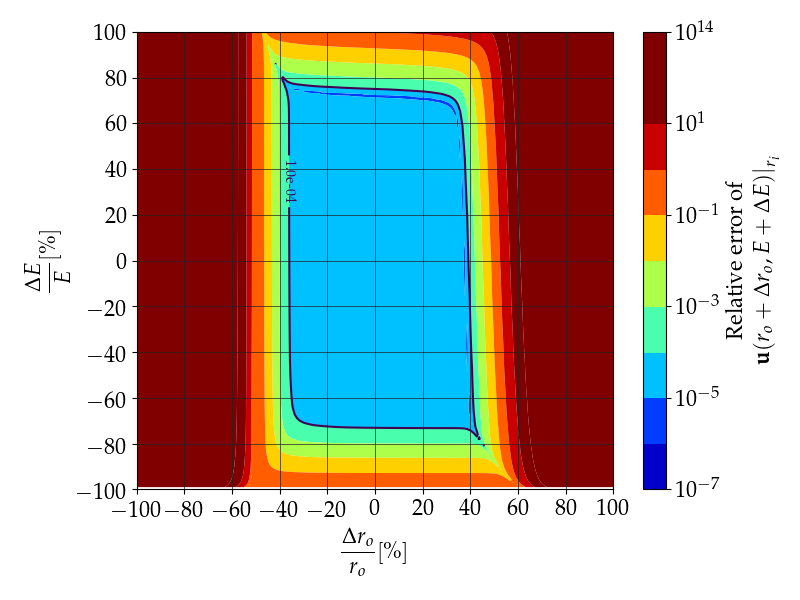

In [115]:
from matplotlib import ticker, cm, colors

fig = plt.figure(figsize=(8,6))
lev_exp = np.array([-7,-6,-5,-4,-3,-2,-1,0,1,2,14],dtype=np.float64)
levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

# cp = plt.contourf(100*Tr/ro.real,100*TE/E.real,error_ti[0], levels=16,locator=ticker.LogLocator(10),norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
cp = plt.contourf(100*Tr/ro.real,100*TE/E.real,error_ti[0], levs,antialiased=True, norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
cbar = fig.colorbar(cp)

CS=plt.contour(100*Tr/ro.real,100*TE/E.real,error_ti[0], [1e-4])

plt.clabel(CS,fmt="%.1e", inline=1, fontsize=10)

cbar.ax.set_ylabel("Relative error of \n$\\left.\\mathbf{u}(r_o+\\Delta r_o, E+\\Delta E)\\right|_{r_i}$")
plt.xlabel("$\\displaystyle{\\frac{\Delta r_o}{r_o}} [ \% ]$")
plt.ylabel("$\\displaystyle{\\frac{\Delta E}{E}} [ \% ]$")


ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(20))

ax.yaxis.set_major_locator(MultipleLocator(20))

plt.grid(color='#222222', linewidth=0.5)
# plt.axis([-50,50,-100,100])

plt.tight_layout()
plt.savefig('imgs/error_ti_Ero.pdf',dpi=150)
plt.show()

<IPython.core.display.Javascript object>


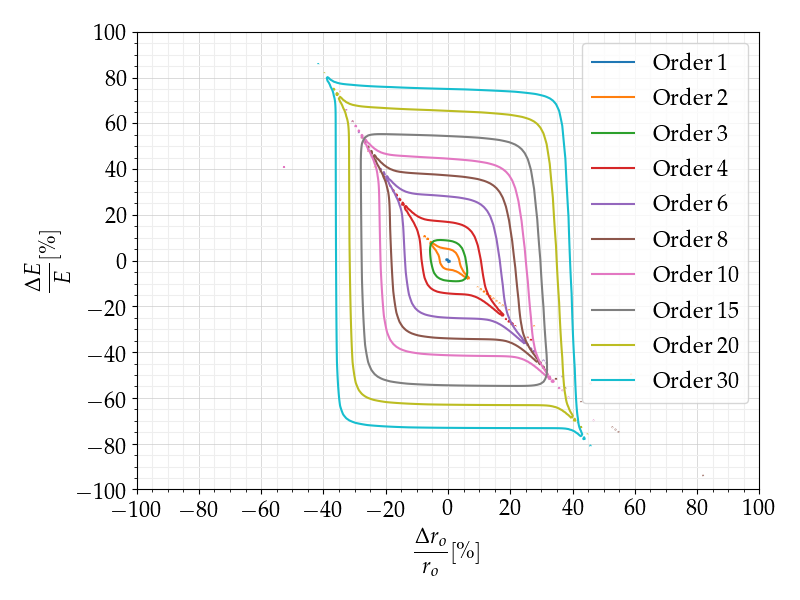

In [64]:
from matplotlib import ticker, cm, colors

rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})
             
fig = plt.figure(figsize=(8,6))
lev_exp = np.array([-7,-6,-5,-4,-3,-2,-1,0,1,2,14],dtype=np.float64)
levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

# cp = plt.contourf(100*Tr/ro.real,100*TE/E.real,error_ti[0], levels=16,locator=ticker.LogLocator(10),norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
# cp = plt.contourf(100*Tr/ro.real,100*TE/E.real,error_ti[0], levs,antialiased=True, norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
# cbar = fig.colorbar(cp)

for kk in range(len(orders_ti)):
    CS=plt.contour(100*Tr/ro.real,100*TE/E.real,error_ti[-1-kk], [1e-4], colors = 'C'+str(kk))
    
#     plt.clabel(CS,fmt='Order '+str(orders_ti[kk]), inline=1, fontsize=12, colors='k')
#     plt.clabel(CS,fmt='Ord. '+str(orders_ti[-1-kk]), inline=1, fontsize=8, colors='k')
    
    CS.collections[0].set_label('Order '+str(orders_ti[-1-kk]))

# cbar.ax.set_ylabel("Relative error of \n$\\left.\\mathbf{u}(r_o+\\Delta r_o, E+\\Delta E)\\right|_{r_i}$")
plt.xlabel("$\\displaystyle{\\frac{\Delta r_o}{r_o}} [ \% ]$")
plt.ylabel("$\\displaystyle{\\frac{\Delta E}{E}} [ \% ]$")


ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.grid(which='major',color='#CCCCCC', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor',color='#EEEEEE')

# plt.axis([-50,50,-100,100])
plt.legend()
plt.tight_layout()
plt.savefig('imgs/error_ti_Ero_orders.pdf',dpi=150)
plt.show()

<IPython.core.display.Javascript object>


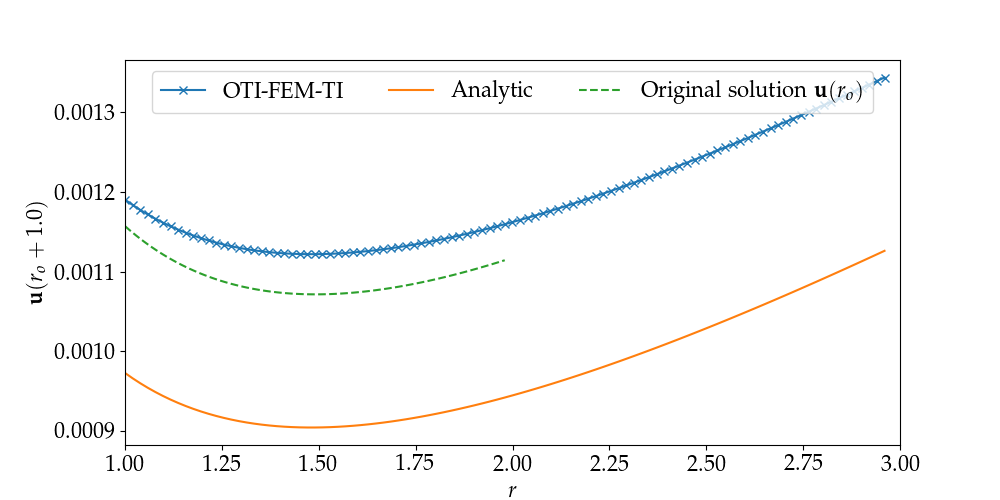

/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


In [127]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})

plt.figure(figsize=(10,5))






delta = 1.0







u_r_ti = np.linalg.norm(u.taylor_integrate([1],[delta]).real,axis=1).reshape((u.shape[0],-1))


grid = Th.to_pv(pd = [u_r_ti],pd_names=['u'])
eps = 1e-2

a = [(ri.real+eps)*np.cos(np.pi/6),(ri.real+eps)*np.sin(np.pi/6),0]
b = [(ro.real-eps)*np.cos(np.pi/6),(ro.real-eps)*np.sin(np.pi/6),0]

grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

ax = plt.gca()

lines = ax.get_lines()
line = lines[0]
line.set_label("OTI-FEM-TI")
line.set_marker("x")

x = line.get_xdata()
line.set_xdata(x*(1+delta)+ri.real)










ux_a_ti, uy_a_ti = analytic_solution_xy(Th.x.taylor_integrate([1],[delta]).real,
                                        Th.y.taylor_integrate([1],[delta]).real,
                                        E.real,nu.real,ri.real,Pi.real,
                                        ro.taylor_integrate([1],[delta]).real,Po.real)
u_a_ti = np.zeros(u.shape)
u_a_ti[:,0:1]=ux_a_ti
u_a_ti[:,1:2]=uy_a_ti
u_ra_ti = np.linalg.norm(u_a_ti.real,axis=1).reshape((u_a.shape[0],-1))

















grid = Th.to_pv(pd = [u_ra_ti],pd_names=['ua'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

lines = ax.get_lines()
line = lines[-1]
line.set_label("Analytic")

x = line.get_xdata()
line.set_xdata(x*(1+delta)+ri.real)













grid = Th.to_pv(pd = [u_ra],pd_names=['ua'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

lines = ax.get_lines()
line = lines[-1]
line.set_label("Original solution $\mathbf{u}(r_o)$")

x = line.get_xdata()
line.set_xdata(x+ri.real)
line.set_linestyle('--')















plt.xlabel("$r$")
plt.ylabel("$\\mathbf{{u}}(r_o+{0})$".format(delta))
# plt.title("OTI solution vs Analytic solution")
plt.title("")
plt.legend(loc='upper center', ncol=3)
plt.axis([ri.real,ro.real+delta,None,None])
plt.savefig("imgs/solution_u_ti_delta_{0}.pdf".format(delta),dpi=150)
#plt.legend()
plt.show()

<IPython.core.display.Javascript object>


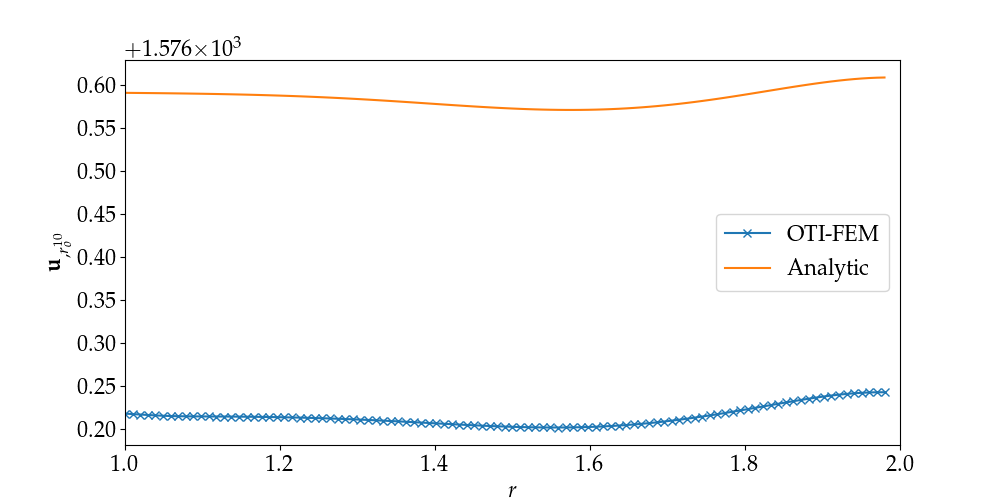

In [42]:
plt.figure(figsize=(10,5))


new_order = 10

dudE = u.get_deriv( [[1,new_order]] )
dudE[0,0:2] = np.nan
dudE_r = np.linalg.norm(dudE.real,axis=1).reshape((dudE.shape[0],-1))
dudE_r



dudE_a = u_a.get_deriv([[1,new_order]])
dudE_a[0,0:2] = np.nan
dudE_ra = np.linalg.norm(dudE_a.real,axis=1).reshape((dudE_a.shape[0],-1))






grid = Th.to_pv(pd = [dudE_r],pd_names=['oti'])

eps = 1e-2

a = [(ri.real+eps)*np.cos(np.pi/6),(ri.real+eps)*np.sin(np.pi/6),0]
b = [(ro.real-eps)*np.cos(np.pi/6),(ro.real-eps)*np.sin(np.pi/6),0]

grid.plot_over_line(a, b, resolution=100, figure=False, show=False )
ax = plt.gca()

lines = ax.get_lines()
line = lines[0]
line.set_label("OTI-FEM")
line.set_marker("x")


x = line.get_xdata()
line.set_xdata(x+ri.real)





grid = Th.to_pv(pd = [dudE_ra],pd_names=['analytic'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )
ax = plt.gca()
lines = ax.get_lines()
line = lines[-1]
line.set_label("Analytic")
x = line.get_xdata()
line.set_xdata(x+ri.real)


# Rescale x axis
# for line in lines:
    



plt.xlabel("$r$")
# plt.ylabel("30th order derivative of u w.r.t. E")
# plt.title("OTI solution vs Analytic solution")
plt.title("")
str_order = " "
if new_order != 1:
    str_order = str(new_order)
# end if 
plt.ylabel("$\\mathbf{u}_{,r_{o}^{"+str_order+"}}$")
plt.legend()#loc='upper right')
plt.axis([ri.real,ro.real,None,None])
plt.savefig('imgs/solution_dudro_n'+str(new_order)+'.pdf',dpi=150)
plt.show()

numpy.ndarray

In [141]:
import pyvista as pv
p = pv.BackgroundPlotter()
args_cbar = dict(height=0.75, vertical=True, position_x=0.05, 
                 position_y=0.05, interactive=False,
                 title_font_size=30, label_font_size=30)

In [147]:
p.set_background("white")

pert = Th.x.get_deriv([1])
grid = Th.to_pv(pd = [pert],pd_names=['Perturbation'])

factor = 100
p.clear()

p.add_mesh(grid.warp_by_scalar(factor=1), show_edges=True, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args=args_cbar)
# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,color='grey', scalar_bar_args=args_cbar)
# p.add_mesh(arrows, lighting=False, stitle="u", scalar_bar_args=args_cbar)
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()


In [125]:
grid.save("cylinder_pert.vtk")

1

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
# pv.set_plot_theme('default')
p.set_background("white")
grid = Th.to_pv(pd = [u_a.real],pd_names=['u'])
factor = 100
p.clear()

# arrows = grid.glyph(scale="u", orient="u", factor = 100,tolerance=0.001)

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args=args_cbar)
# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,color='grey', scalar_bar_args=args_cbar)
# p.add_mesh(arrows, lighting=False, stitle="u", scalar_bar_args=args_cbar)
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()


In [ ]:
arrows

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
# pv.set_plot_theme('default')
p.set_background("white")
grid = Th.to_pv(pd = [u.real],pd_names=['u'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args=args_cbar)
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u_a.real],pd_names=['u_analytic'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [np.abs((u_r-u_ra)/u_ra)],pd_names=['relative error'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet')#, scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u.real-u_a.real],pd_names=['absolute error'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet')#, scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u.real-u_a.real],pd_names=['absolute error'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet')#, scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
import pyvista as pv
p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u_rerr],pd_names=['relative error'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet')#, scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [dudEc],pd_names=['dudE_oti'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [dudE_analytic],pd_names=['dudE_analytic'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
import pyvista as pv
p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [dudE-dudE_analytic],pd_names=['10th deriv  abs. error.'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
x = Th.x.real
y = Th.y.real

In [27]:
# Analytic solution
def analytic_solution_s(x,y,E,nu,ri,pi,ro,po):
    
    A = ri**2*ro**2*(po-pi)/(ro**2-ri**2)
    B = (ri**2*pi - ro**2*po)/(ro**2-ri**2)

    
    r =  (x**2+y**2)**0.5
    
    ur = (1+nu)*r/E*((1-2*nu)*B-A/(r**2))
    
#     ux = ur*x/r
#     uy = ur*y/r
    
    return ur

In [28]:

import sympy as sym
Es, nus, ris, Pis, ros, Pos, xs, ys = sym.symbols("E nu r_i P_i r_o P_o x y")

In [29]:
urs = analytic_solution_s(xs,ys,Es,nus,ris,Pis,ros,Pos)
d30udE = urs.diff(Es,30)

In [30]:
d30udE

-265252859812191058636308480000000*(nu + 1)*(x**2 + y**2)**0.5*(r_i**2*r_o**2*(P_i - P_o)*(x**2 + y**2)**(-1.0) - (2*nu - 1)*(P_i*r_i**2 - P_o*r_o**2))/(E**31*(r_i**2 - r_o**2))

In [48]:
factor = 1
for i in range(1,31):
    factor *= i
factor

265252859812191058636308480000000

In [ ]:
ux_eval = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos],uxs)
duxdE_eval = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos],uxs.diff(Es,1))

uy_eval = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos],uys)
duydE_eval = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos],uys.diff(Es,1))

In [ ]:
ux_eval(1,0,E.real,nu.real,ri.real, Pi.real, ro.real, Po.real)

In [ ]:
duxdE_eval(1,0,E.real,nu.real,ri.real, Pi.real, ro.real, Po.real)

In [31]:
d30udE_eval =  sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos], d30udE)

In [32]:
d30udE_eval(0,ri.real,E.real,nu.real,ri.real,Pi.real,ro.real,Po.real)

-6.6376214518194285e-161

In [21]:
a_sol = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos], d30udro)

In [22]:
a_sol(0,ri.real,E.real,nu.real,ri.real,Pi.real,ro.real,Po.real)

-1.1524403107115262e+29

In [55]:
idx = int(idx)

In [56]:
deriv = urs

evals = np.zeros(order+1)

for k in range(0,order+1):

    deriv_eval = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos], deriv)
    evals[k] = deriv_eval(Th.x[idx,0].real,Th.y[idx,0].real,E.real,nu.real,ri.real,Pi.real,ro.real,Po.real)
    deriv = deriv.diff(Es)
    
evals = np.abs(evals)  


In [57]:
evals

array([1.11566259e-003, 5.31267901e-010, 5.05969429e-016, 7.22813470e-022,
       1.37678756e-027, 3.27806563e-033, 9.36590179e-039, 3.12196726e-044,
       1.18932086e-049, 5.09708941e-055, 2.42718543e-060, 1.27138285e-065,
       7.26504483e-071, 4.49740870e-076, 2.99827247e-081, 2.14162319e-086,
       1.63171291e-091, 1.32091045e-096, 1.13220896e-101, 1.02437953e-106,
       9.75599555e-112, 9.75599555e-117, 1.02205668e-121, 1.11939541e-126,
       1.27930904e-131, 1.52298695e-136, 1.88560289e-141, 2.42434657e-146,
       3.23246210e-151, 4.46387623e-156, 6.37696604e-161])

In [42]:
evals[0]

-0.0011156723809523808

In [58]:
u_ra[idx,0]

0.0011156625914466793

In [59]:
evals[0]

0.0011156625914466795

In [60]:
# Compute the relative errors of the derivative dudro(ri) for all computed orders.
idx = i
errors = np.zeros(order+1)

u_rerr = np.abs(u_r - evals[0])/np.abs(evals[0])

errors[0] = np.abs(u_rerr[idx,0])

for ordi in range(1,order + 1):
    dudE = u.get_deriv( [[1,ordi]] )
    dudE[0,0:2] = np.nan
    dudE_r = np.linalg.norm(dudE.real,axis=1).reshape((dudE.shape[0],-1))
    
    
    dudE_rerr=np.abs(dudE_r - evals[ordi])/np.abs(evals[ordi]) #6.6376214518194285e-161
    errors[ordi] = np.abs(dudE_rerr[idx,0])
# end for 
errors

array([1.68228122e-05, 1.68228143e-05, 1.68228161e-05, 1.68228181e-05,
       1.68228200e-05, 1.68228213e-05, 1.68228234e-05, 1.68228253e-05,
       1.68228261e-05, 1.68228284e-05, 1.68228298e-05, 1.68228312e-05,
       1.68228327e-05, 1.68228351e-05, 1.68228366e-05, 1.68228387e-05,
       1.68228406e-05, 1.68228423e-05, 1.68228447e-05, 1.68228467e-05,
       1.68228482e-05, 1.68228496e-05, 1.68228513e-05, 1.68228531e-05,
       1.68228546e-05, 1.68228564e-05, 1.68228579e-05, 1.68228597e-05,
       1.68228622e-05, 1.68228637e-05, 5.03289566e-05])

In [48]:
u_ra[idx,0]

0.001161264761904762